# AutoMpg Dataset
"The data concerns city-cycle fuel consumption in miles per gallon, to be predicted in terms of 3 multivalued discrete and 5 continuous attributes." (Quinlan, 1993)"
- 398 instances
- 7 features

In [5]:
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestRegressor as SklearnRandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ParameterGrid, KFold

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

### Loading Configuration and Data

In [6]:
def load_config(config_path):
    with open(config_path, 'r') as file:
        return yaml.safe_load(file)

config = load_config("config.yaml")

In [7]:
data_path = config['paths']['path_auto']
columns = [
    "mpg", "cylinders", "displacement", "horsepower",
    "weight", "acceleration", "model_year", "origin", "car_name"
]
auto_data = pd.read_csv(data_path, delim_whitespace=True, names=columns, na_values="?")

### Data Analysis

In [27]:
print(auto_data.head())

    mpg  cylinders  displacement  horsepower  weight  acceleration  \
0  18.0          8         307.0       130.0  3504.0          12.0   
1  15.0          8         350.0       165.0  3693.0          11.5   
2  18.0          8         318.0       150.0  3436.0          11.0   
3  16.0          8         304.0       150.0  3433.0          12.0   
4  17.0          8         302.0       140.0  3449.0          10.5   

   model_year  origin                   car_name  
0          70       1  chevrolet chevelle malibu  
1          70       1          buick skylark 320  
2          70       1         plymouth satellite  
3          70       1              amc rebel sst  
4          70       1                ford torino  


In [28]:
print(auto_data.describe())

              mpg   cylinders  displacement  horsepower       weight  \
count  398.000000  398.000000    398.000000  392.000000   398.000000   
mean    23.514573    5.454774    193.425879  104.469388  2970.424623   
std      7.815984    1.701004    104.269838   38.491160   846.841774   
min      9.000000    3.000000     68.000000   46.000000  1613.000000   
25%     17.500000    4.000000    104.250000   75.000000  2223.750000   
50%     23.000000    4.000000    148.500000   93.500000  2803.500000   
75%     29.000000    8.000000    262.000000  126.000000  3608.000000   
max     46.600000    8.000000    455.000000  230.000000  5140.000000   

       acceleration  model_year      origin  
count    398.000000  398.000000  398.000000  
mean      15.568090   76.010050    1.572864  
std        2.757689    3.697627    0.802055  
min        8.000000   70.000000    1.000000  
25%       13.825000   73.000000    1.000000  
50%       15.500000   76.000000    1.000000  
75%       17.175000   79.0000

In [29]:
print(auto_data.isnull().sum())

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
car_name        0
dtype: int64


##### Target Analysis

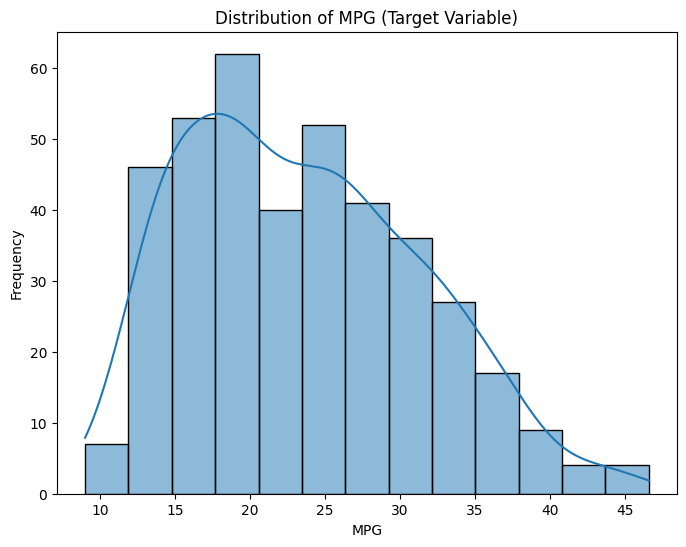

In [65]:
plt.figure(figsize=(8, 6))
sns.histplot(auto_data['mpg'], kde=True)
plt.title('Distribution of MPG (Target Variable)')
plt.xlabel('MPG')
plt.ylabel('Frequency')
plt.show()

##### Numerical Variables Analysis 

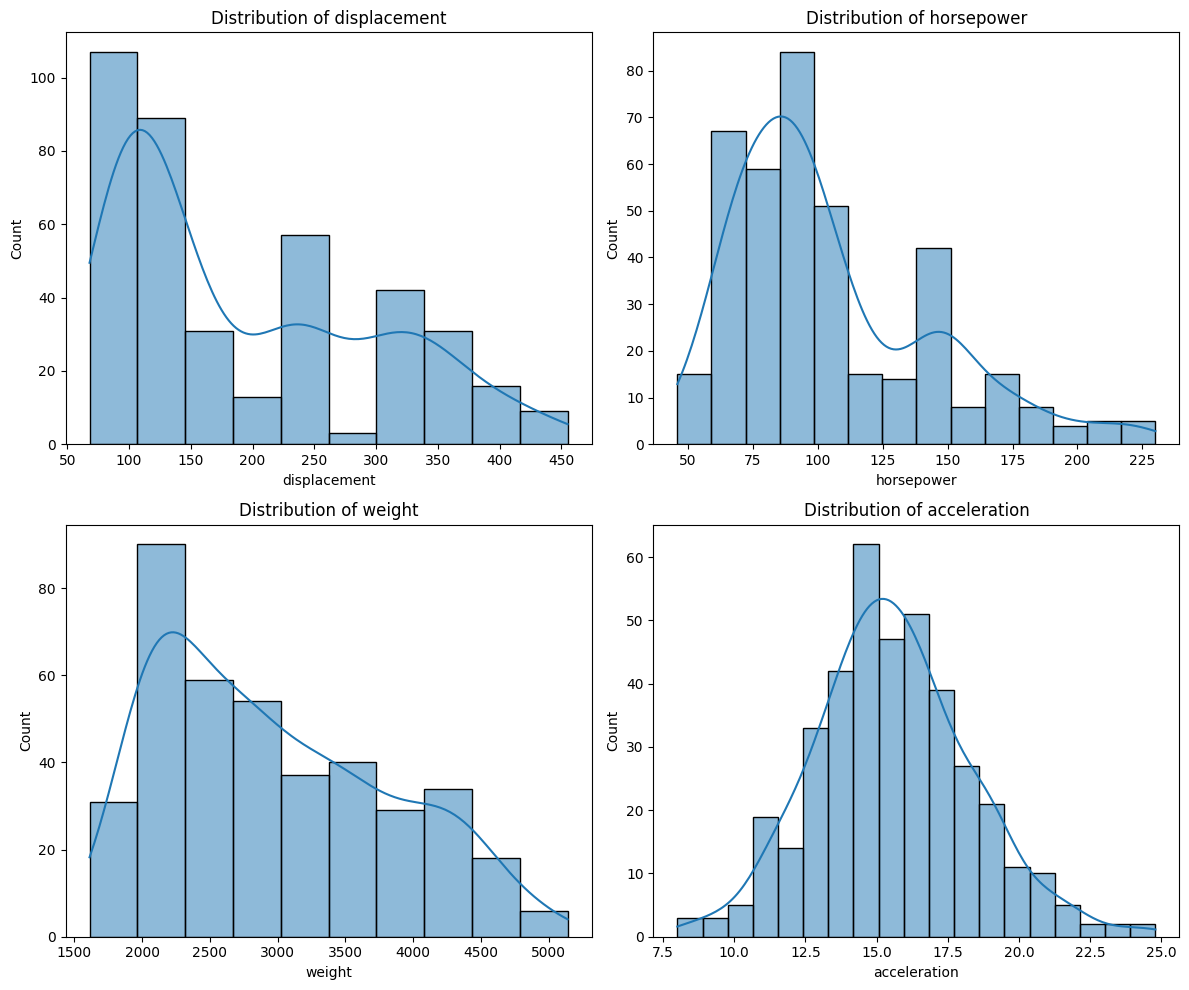

In [64]:
numerical_f = ["displacement", "horsepower", "weight", "acceleration"]
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, feature in enumerate(numerical_f):
    sns.histplot(auto_data[feature].dropna(), kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {feature}")

plt.tight_layout()
plt.show()

##### Categorical Variables Analysis 

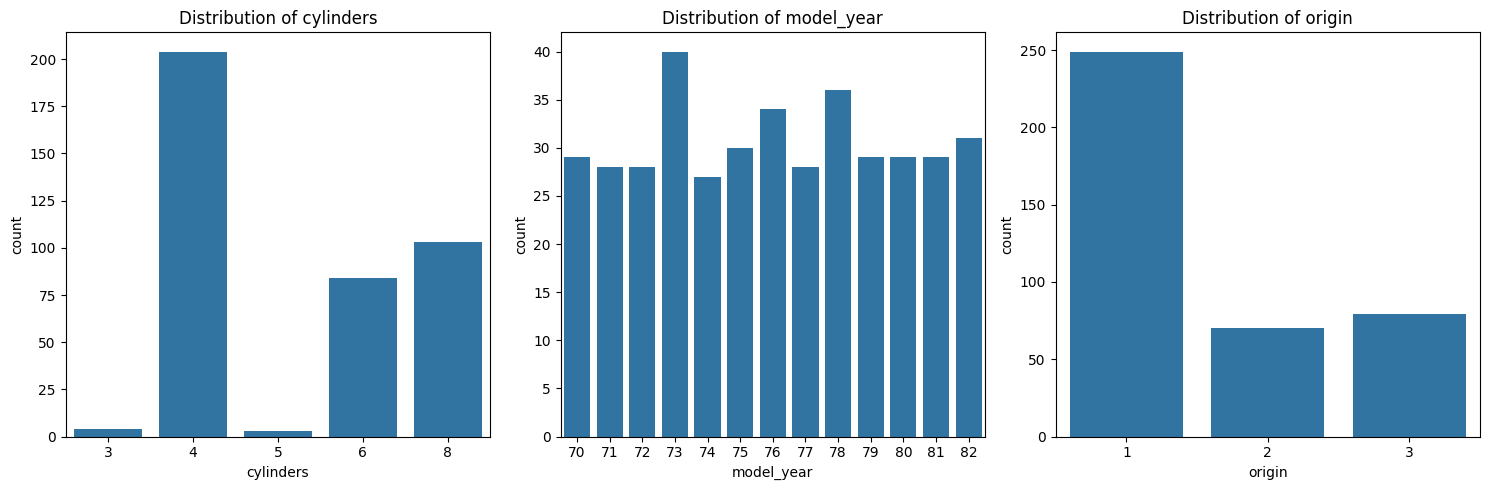

In [32]:
categorical_f = ["cylinders", "model_year", "origin"]
fig, axes = plt.subplots(1, len(categorical_f), figsize=(15, 5))
axes = axes.flatten()

for i, feature in enumerate(categorical_f):
    sns.countplot(data=auto_data, x=feature, ax=axes[i])
    axes[i].set_title(f"Distribution of {feature}")

plt.tight_layout()
plt.show()

##### Coorelation Analysis

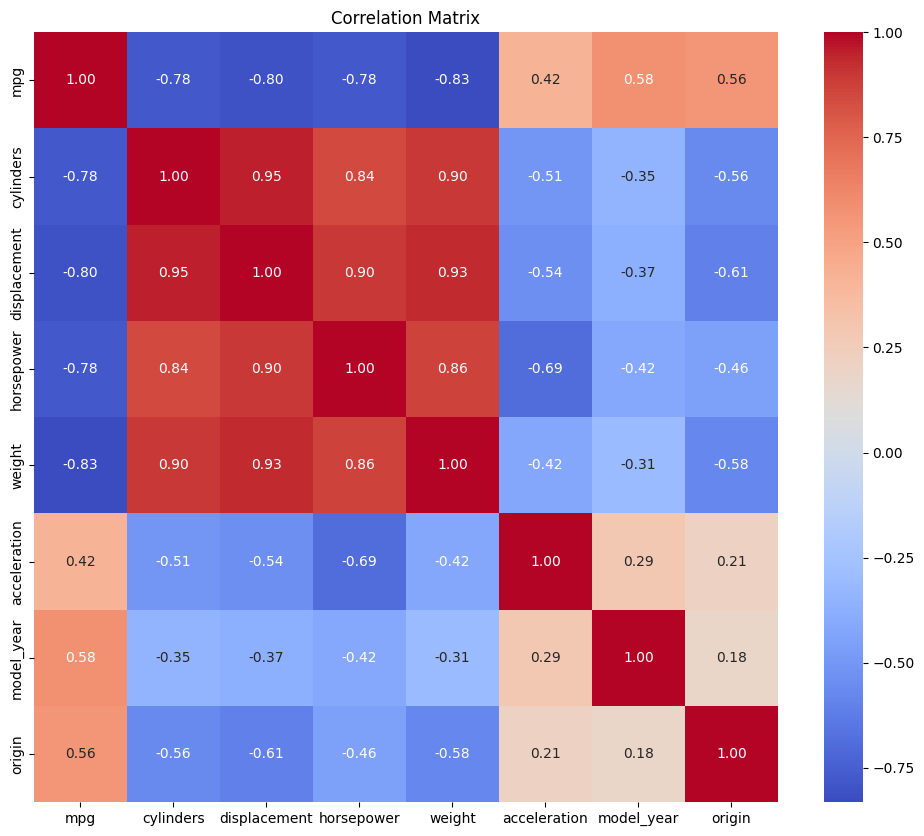

In [68]:
plt.figure(figsize=(12, 10))
sns.heatmap(auto_data.corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix")
plt.show()

### Data Splitting & Preprocessing

In [34]:
auto_data = auto_data.drop('car_name', axis=1)

In [35]:
X = auto_data.drop('mpg', axis=1)
y = auto_data['mpg']

In [36]:
test_size = config['split']['test_size']
validation_size = config['split']['validation_size']
random_state = config['split']['random_state']

In [37]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,
    test_size=test_size,
    random_state=random_state
)
val_size_relative = validation_size / (1 - test_size)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=val_size_relative,
    random_state=random_state
)
print(X_train.shape[0])
print(X_val.shape[0])
print(X_test.shape[0])

278
40
80


In [38]:
imputer = SimpleImputer(strategy='median')
X_train['horsepower'] = imputer.fit_transform(X_train[['horsepower']])
X_val['horsepower'] = imputer.transform(X_val[['horsepower']])
X_test['horsepower'] = imputer.transform(X_test[['horsepower']])

In [39]:
#scaler = StandardScaler()
#X_train_scaled = X_train.copy()
#X_val_scaled = X_val.copy()
#X_test_scaled = X_test.copy()

#X_train_scaled[numerical_f] = scaler.fit_transform(X_train[numerical_f])
#X_val_scaled[numerical_f] = scaler.transform(X_val[numerical_f])
#X_test_scaled[numerical_f] = scaler.transform(X_test[numerical_f])

##idk if i should scale as random forest doesnt need scaling 
##but for the other regressors why would i scale as i compar it with mine?!


## Modelling

In [40]:
def evaluate_model(y_true, y_pred):
    return {
        "MSE": mean_squared_error(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred)
    }

In [41]:
#Grid Search for Scratch Models
def grid_search_custom_model(model_class, param_grid, X_train, y_train, cv=5):
    best_params = None
    best_score = float('inf')  # Lower is better (e.g., MSE)
    all_results = []

    # Iterate over parameter combinations
    for params in ParameterGrid(param_grid):
        cv_scores = []
        kf = KFold(n_splits=cv, shuffle=True, random_state=42)
        for train_idx, val_idx in kf.split(X_train):
            X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
            y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

            # Train the model
            model = model_class(**params)
            model.fit(X_train_fold, y_train_fold)
            
            # Predict and evaluate
            y_pred = model.predict(X_val_fold)
            cv_scores.append(mean_squared_error(y_val_fold, y_pred))
        
        avg_score = np.mean(cv_scores)
        all_results.append((params, avg_score))
        if avg_score < best_score:
            best_score = avg_score
            best_params = params

    return best_params, best_score, all_results

In [42]:
custom_rf_param_grid = {
    'n_estimators': config['rf_params']['n_trees'], 
    'max_depth': config['rf_params']['max_depth'],
    'min_samples_split': config['rf_params']['min_samples_split'],
    'max_features': config['rf_params']['max_features']
}

#### Random Forest Regression tree from Scratch

In [43]:
class RegressionTreeScratch:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y)

    def predict(self, X):
        return np.array([self._predict(inputs) for inputs in X])

    def _build_tree(self, X, y, depth=0):
        num_samples = len(y)
        if (self.max_depth is not None and depth >= self.max_depth) or num_samples < self.min_samples_split:
            leaf_value = np.mean(y)
            return leaf_value

        best_feature, best_threshold = self._best_split(X, y)
        if best_feature is None:
            return np.mean(y)

        left_indices = X[:, best_feature] <= best_threshold
        right_indices = X[:, best_feature] > best_threshold

        left_subtree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return {'feature_index': best_feature, 'threshold': best_threshold,
                'left': left_subtree, 'right': right_subtree}

    def _best_split(self, X, y):
        best_feature, best_threshold = None, None
        best_variance_reduction = -float('inf')
        n_samples, n_features = X.shape
        for feature_index in range(n_features):
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                left_indices = X[:, feature_index] <= threshold
                right_indices = X[:, feature_index] > threshold
                if len(y[left_indices]) == 0 or len(y[right_indices]) == 0:
                    continue
                variance_reduction = self._variance_reduction(y, y[left_indices], y[right_indices])
                if variance_reduction > best_variance_reduction:
                    best_variance_reduction = variance_reduction
                    best_feature = feature_index
                    best_threshold = threshold
        return best_feature, best_threshold

    def _variance_reduction(self, parent, left, right):
        weight_left = len(left) / len(parent)
        weight_right = len(right) / len(parent)
        reduction = np.var(parent) - (weight_left * np.var(left) + weight_right * np.var(right))
        return reduction

    def _predict(self, inputs):
        node = self.tree
        while isinstance(node, dict):
            if inputs[node['feature_index']] <= node['threshold']:
                node = node['left']
            else:
                node = node['right']
        return node

In [44]:
class RandomForestRegressorScratch:
    def __init__(self, n_estimators=10, max_depth=None, min_samples_split=2, max_features=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.trees = []
        self.feature_indices = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.trees = []
        self.feature_indices = []
        for _ in range(self.n_estimators):
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_sample = X[indices]
            y_sample = y[indices]
            if self.max_features is None:
                max_features = n_features
            elif self.max_features == 'sqrt':
                max_features = int(np.sqrt(n_features))
            elif self.max_features == 'log2':
                max_features = int(np.log2(n_features))
            else:
                max_features = self.max_features
            features = np.random.choice(n_features, max_features, replace=False)
            self.feature_indices.append(features)
            X_sample = X_sample[:, features]
            tree = RegressionTreeScratch(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        predictions = []
        for tree, features in zip(self.trees, self.feature_indices):
            X_subset = X[:, features]
            predictions.append(tree.predict(X_subset))
        predictions = np.mean(predictions, axis=0)
        return predictions

In [45]:
# Perform grid search for custom RF
best_custom_rf_params, best_custom_rf_score, custom_rf_results = grid_search_custom_model(
    RandomForestRegressorScratch, custom_rf_param_grid, X_train.values, y_train.values
)

In [46]:

# Train the best Custom RF on the entire training set
best_custom_rf = RandomForestRegressorScratch(**best_custom_rf_params)
best_custom_rf.fit(X_train.values, y_train.values)


#### LLM Random Forest Regression tree from Scratch

In [47]:
class RegressionTreeLLM:
    """
    A regression tree for predicting continuous values using variance reduction.
    """

    def __init__(self, max_depth=None, min_samples_split=2):
        """
        Initializes the regression tree with hyperparameters.

        Parameters:
        - max_depth (int): Maximum depth of the tree.
        - min_samples_split (int): Minimum number of samples required to split an internal node.
        """
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def fit(self, X, y):
        """
        Builds the tree by fitting the model to the data.

        Parameters:
        - X (array-like): Feature matrix.
        - y (array-like): Target vector.
        """
        self.root = self._build_tree(X, y)

    def predict(self, X):
        """
        Predicts target values for given input data.

        Parameters:
        - X (array-like): Feature matrix.

        Returns:
        - predictions (array-like): Predicted values.
        """
        return np.array([self._predict(inputs, self.root) for inputs in X])

    def _build_tree(self, X, y, depth=0):
        num_samples = len(y)

        # Stopping conditions
        if (self.max_depth is not None and depth >= self.max_depth) or num_samples < self.min_samples_split:
            leaf_value = self._calculate_leaf_value(y)
            return Node(value=leaf_value)

        # Find the best split
        best_split = self._get_best_split(X, y)
        if not best_split or best_split['variance_reduction'] <= 0:
            leaf_value = self._calculate_leaf_value(y)
            return Node(value=leaf_value)

        # Recursive splitting
        left_subtree = self._build_tree(best_split['X_left'], best_split['y_left'], depth + 1)
        right_subtree = self._build_tree(best_split['X_right'], best_split['y_right'], depth + 1)

        return Node(
            feature_index=best_split['feature_index'],
            threshold=best_split['threshold'],
            left=left_subtree,
            right=right_subtree
        )

    def _get_best_split(self, X, y):
        """
        Finds the best split by maximizing variance reduction.

        Returns:
        - best_split (dict): Dictionary containing the best split parameters.
        """
        n_samples, n_features = X.shape
        best_split = {}
        max_variance_reduction = -float('inf')

        for feature_index in range(n_features):
            feature_values = X[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            for threshold in possible_thresholds:
                X_left, y_left, X_right, y_right = self._split(X, y, feature_index, threshold)
                if len(y_left) > 0 and len(y_right) > 0:
                    variance_reduction = self._variance_reduction(y, y_left, y_right)
                    if variance_reduction > max_variance_reduction:
                        max_variance_reduction = variance_reduction
                        best_split = {
                            'feature_index': feature_index,
                            'threshold': threshold,
                            'X_left': X_left,
                            'y_left': y_left,
                            'X_right': X_right,
                            'y_right': y_right,
                            'variance_reduction': variance_reduction
                        }
        return best_split if best_split else None

    def _split(self, X, y, feature_index, threshold):
        """
        Splits the dataset into left and right subsets.

        Parameters:
        - feature_index (int): Index of the feature to split on.
        - threshold (float): Threshold value to split at.

        Returns:
        - X_left, y_left, X_right, y_right: Split datasets.
        """
        left_indices = X[:, feature_index] <= threshold
        right_indices = X[:, feature_index] > threshold
        return X[left_indices], y[left_indices], X[right_indices], y[right_indices]

    def _variance_reduction(self, y, y_left, y_right):
        """
        Calculates variance reduction from the split.

        Returns:
        - variance_reduction (float): Amount of variance reduced.
        """
        weight_left = len(y_left) / len(y)
        weight_right = len(y_right) / len(y)
        reduction = np.var(y) - (weight_left * np.var(y_left) + weight_right * np.var(y_right))
        return reduction

    def _calculate_leaf_value(self, y):
        """
        Calculates the value of a leaf node.

        Returns:
        - leaf_value (float): Mean of the target values.
        """
        return np.mean(y)

    def _predict(self, inputs, node):
        """
        Recursively traverses the tree to make a prediction.

        Parameters:
        - inputs (array-like): Single sample features.
        - node (Node): Current node in the tree.

        Returns:
        - prediction (float): Predicted value.
        """
        if node.is_leaf():
            return node.value
        if inputs[node.feature_index] <= node.threshold:
            return self._predict(inputs, node.left)
        else:
            return self._predict(inputs, node.right)
class Node:
    """
    Represents a node in the regression tree.
    """

    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        """
        Initializes a node.

        Parameters:
        - feature_index (int): Index of the feature used for splitting.
        - threshold (float): Threshold value for splitting.
        - left (Node): Left child node.
        - right (Node): Right child node.
        - value (float): Value at the leaf node.
        """
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf(self):
        """
        Checks if the node is a leaf node.

        Returns:
        - is_leaf (bool): True if leaf node, else False.
        """
        return self.value is not None

In [48]:
class RandomForestRegressorLLM:
    """
    A random forest regressor using the LLM's Regression Tree implementation.
    """

    def __init__(self, n_estimators=10, max_depth=None, min_samples_split=2, max_features=None):
        """
        Initializes the random forest regressor.

        Parameters:
        - n_estimators (int): Number of trees in the forest.
        - max_depth (int): Maximum depth of each tree.
        - min_samples_split (int): Minimum samples to split an internal node.
        - max_features (int, str): Number of features to consider when looking for the best split.
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.trees = []
        self.feature_indices = []

    def fit(self, X, y):
        """
        Fits the random forest to the data.

        Parameters:
        - X (array-like): Feature matrix.
        - y (array-like): Target vector.
        """
        n_samples, n_features = X.shape
        self.trees = []
        self.feature_indices = []
        for _ in range(self.n_estimators):
            # Bootstrap sampling
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_sample = X[indices]
            y_sample = y[indices]

            # Feature selection
            if self.max_features == 'sqrt':
                max_features = int(np.sqrt(n_features))
            elif self.max_features == 'log2':
                max_features = int(np.log2(n_features))
            elif isinstance(self.max_features, int):
                max_features = self.max_features
            else:
                max_features = n_features  # Use all features

            features = np.random.choice(n_features, max_features, replace=False)
            self.feature_indices.append(features)
            X_sample = X_sample[:, features]

            # Train a regression tree
            tree = RegressionTreeLLM(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        """
        Predicts target values for given input data.

        Parameters:
        - X (array-like): Feature matrix.

        Returns:
        - predictions (array-like): Predicted values.
        """
        predictions = []
        for tree, features in zip(self.trees, self.feature_indices):
            X_subset = X[:, features]
            predictions.append(tree.predict(X_subset))
        predictions = np.mean(predictions, axis=0)
        return predictions

In [49]:
# LLM Random Forest
llm_rf_param_grid = custom_rf_param_grid  # Same parameter grid as Custom RF
best_llm_rf_params, best_llm_rf_score, llm_rf_results = grid_search_custom_model(
    RandomForestRegressorLLM, llm_rf_param_grid, X_train.values, y_train.values
)

In [50]:
# Train the best LLM RF on the entire training set
best_llm_rf = RandomForestRegressorLLM(**best_llm_rf_params)
best_llm_rf.fit(X_train.values, y_train.values)

#### Random forest from Sklearn

In [51]:
# Sklearn Random Forest with GridSearchCV
rf_grid = GridSearchCV(SklearnRandomForestRegressor(random_state=random_state), custom_rf_param_grid, cv=5)
rf_grid.fit(X_train, y_train)
best_rf_model = rf_grid.best_estimator_

#### Linear Regression

In [52]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

## Prediction

In [53]:
custom_rf_test_metrics = evaluate_model(y_test, best_custom_rf.predict(X_test.values))
llm_rf_test_metrics = evaluate_model(y_test, best_llm_rf.predict(X_test.values))
rf_test_metrics = evaluate_model(y_test, best_rf_model.predict(X_test))
lr_test_metrics = evaluate_model(y_test, lr.predict(X_test))

## Evaluation

In [54]:
test_results = {
    "Custom Random Forest": custom_rf_test_metrics,
    "LLM Random Forest": llm_rf_test_metrics,
    "Sklearn Random Forest": rf_test_metrics,
    "Linear Regression": lr_test_metrics
}

print("\nTest Results:")
for model, metrics in test_results.items():
    print(f"{model}: {metrics}")



Test Results:
Custom Random Forest: {'MSE': 5.356601834138511, 'MAE': 1.7268422916666673, 'R2': 0.9003727704393968}
LLM Random Forest: {'MSE': 5.313422024102222, 'MAE': 1.7601380456349205, 'R2': 0.9011758700499469}
Sklearn Random Forest: {'MSE': 4.9547977693730685, 'MAE': 1.592735329402834, 'R2': 0.9078459086412412}
Linear Regression: {'MSE': 8.37299111600188, 'MAE': 2.2910170235900673, 'R2': 0.8442710632874639}


In [55]:
test_results_df = pd.DataFrame(test_results).T
test_results_df.to_csv("test_results.csv", index=True)


In [56]:
#best parameters for custom RF and LLM RF
print("\nBest Parameters for Custom Random Forest:", best_custom_rf_params)
print("Best Cross-Validation Score for Custom Random Forest:", best_custom_rf_score)
print("\nBest Parameters for LLM Random Forest:", best_llm_rf_params)
print("Best Cross-Validation Score for LLM Random Forest:", best_llm_rf_score)


Best Parameters for Custom Random Forest: {'max_depth': None, 'max_features': None, 'min_samples_split': 10, 'n_estimators': 100}
Best Cross-Validation Score for Custom Random Forest: 8.454402915581625

Best Parameters for LLM Random Forest: {'max_depth': None, 'max_features': None, 'min_samples_split': 10, 'n_estimators': 10}
Best Cross-Validation Score for LLM Random Forest: 8.442909870751453



Test Results Summary:
                            MSE       MAE        R2
Custom Random Forest   5.356602  1.726842  0.900373
LLM Random Forest      5.313422  1.760138  0.901176
Sklearn Random Forest  4.954798  1.592735  0.907846
Linear Regression      8.372991  2.291017  0.844271


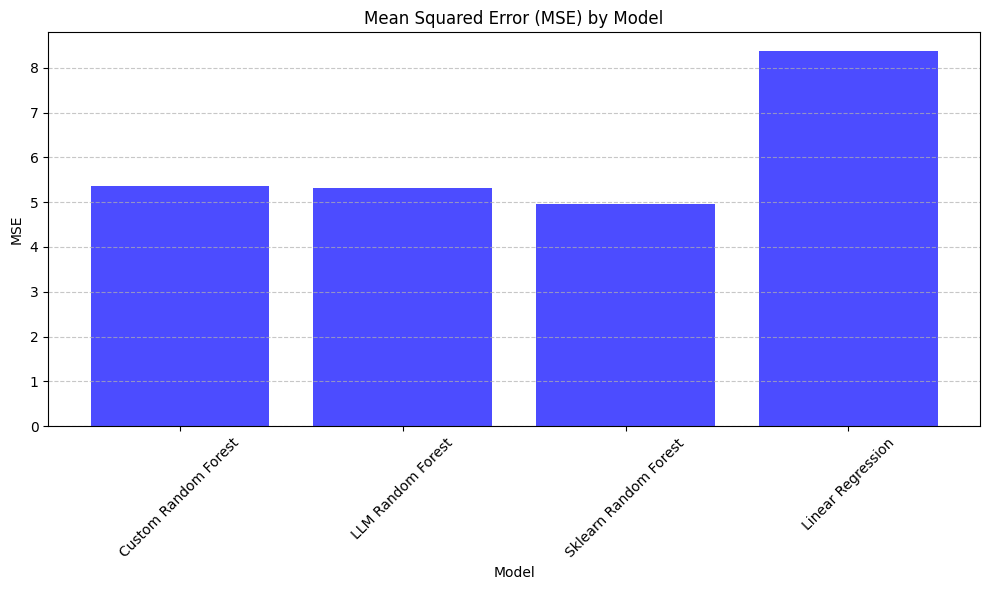

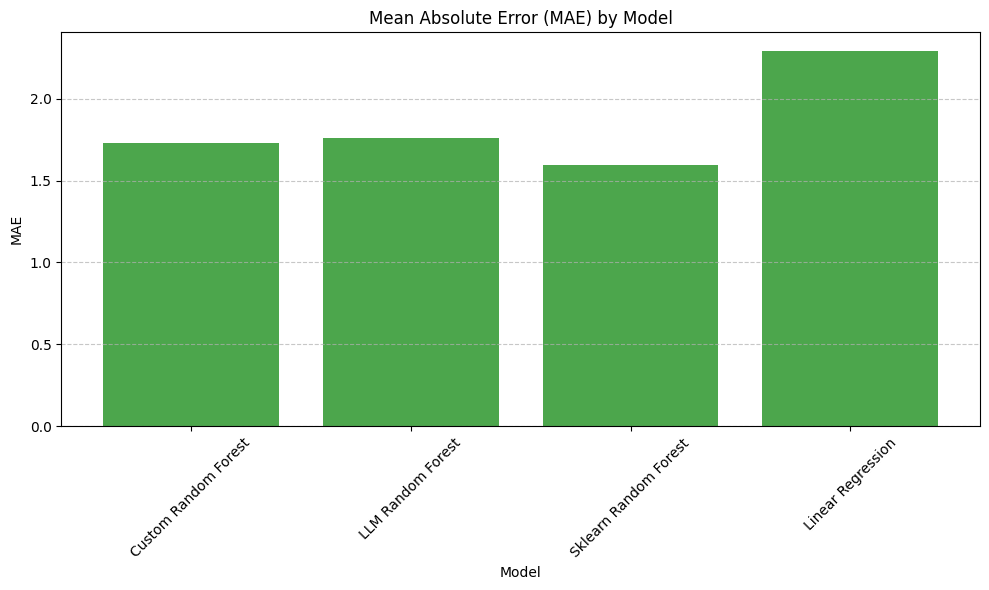

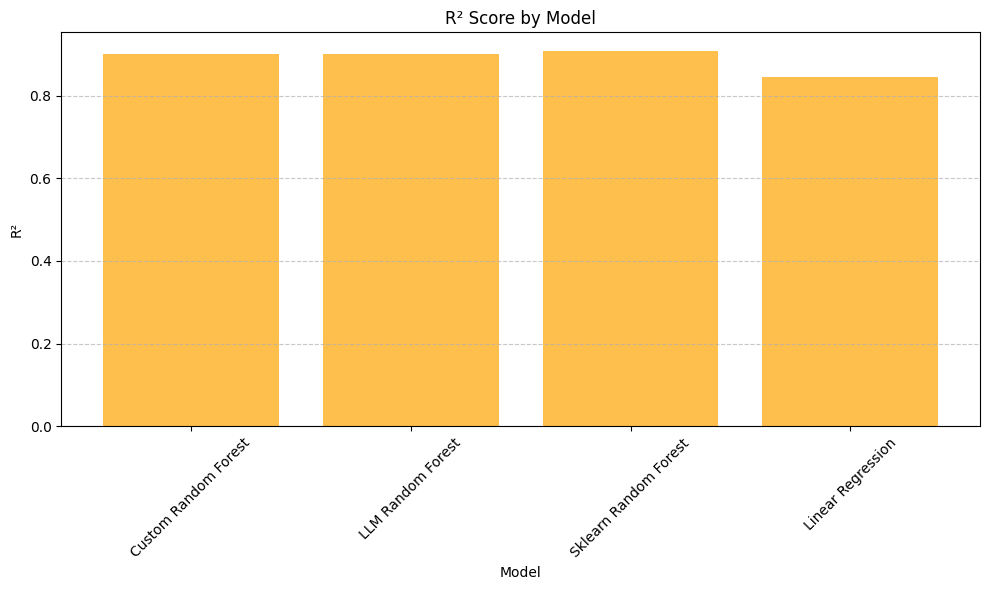

In [61]:
def plot_results(test_results_df):
    models = test_results_df.index
    mse_values = test_results_df['MSE']
    mae_values = test_results_df['MAE']
    r2_values = test_results_df['R2']

    #MSE
    plt.figure(figsize=(10, 6))
    plt.bar(models, mse_values, color='blue', alpha=0.7)
    plt.title("Mean Squared Error (MSE) by Model")
    plt.ylabel("MSE")
    plt.xlabel("Model")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    #MAE
    plt.figure(figsize=(10, 6))
    plt.bar(models, mae_values, color='green', alpha=0.7)
    plt.title("Mean Absolute Error (MAE) by Model")
    plt.ylabel("MAE")
    plt.xlabel("Model")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    #R2
    plt.figure(figsize=(10, 6))
    plt.bar(models, r2_values, color='orange', alpha=0.7)
    plt.title("R² Score by Model")
    plt.ylabel("R²")
    plt.xlabel("Model")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# df for visualization
metrics_flattened = {k: {metric: value for metric, value in v.items()} for k, v in test_results.items()}
test_results_flattened_df = pd.DataFrame.from_dict(metrics_flattened, orient='index')

#save to CSV
test_results_flattened_df.to_csv("detailed_test_results.csv", index=True)

print("\nTest Results Summary:")
print(test_results_flattened_df)

plot_results(test_results_flattened_df)